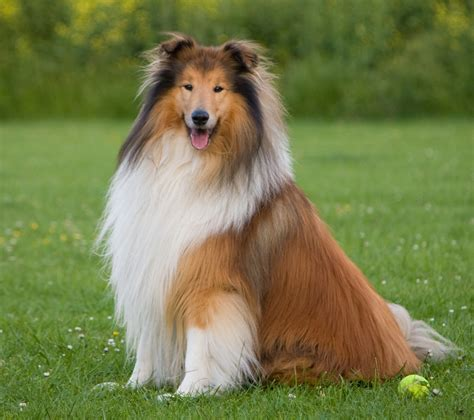

In [10]:
import torch

from torchvision.models.vision_transformer import vit_b_16
from torchvision.models.resnet import resnet50
from torchvision.models.vgg import vgg16
from torchvision.models.swin_transformer import swin_b
from torchvision.models.efficientnet import efficientnet_v2_s
from transformers import AutoModelForImageClassification

import torchvision.transforms as T
from PIL import Image
import timm

device = "cuda:0" if torch.cuda.is_available() else "cpu"



# model = vit_b_16(pretrained=True).to(device)
# model = efficientnet_v2_s(pretrained=True).to(device)
model = swin_b(pretrained=True).to(device)
# model = resnet50(pretrained=True).to(device)
# model = vgg16(pretrained=True).to(device)

transform = T.Compose(
    [
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

model.eval()


# image = Image.open("images/lizard.jpg")
image = Image.open("images/dog.jpeg")
sample = transform(image).unsqueeze(0).to(device)

# load the index to label mapping in "./imagenet1000_clsidx_to_labels.txt" in format
# {number: '<label>',
#  number: '<label>',}
index_to_label = {}

with open("imagenet1000_clsidx_to_labels.txt", "r") as f:
    for line in f:

        line = line.replace("{", "").replace("}", "")            

        line = line.replace(" ", "")
        line = line.replace(",","")
        values = line.split(":")

        values[1] = values[1].replace("'", "").replace('"', "")
        index_to_label[int(values[0])] = values[1].strip("'\"")

image

In [11]:
from zennit.composites import EpsilonPlusFlat
from zennit.canonizers import SequentialMergeBatchNorm
from crp.attribution import CondAttribution

composite = EpsilonPlusFlat([SequentialMergeBatchNorm()])
attribution = CondAttribution(model, no_param_grad=True)


from crp.helper import get_layer_names

# compute heatmap wrt. output 46 (green lizard class)

output_class = torch.argmax(model(sample), dim=1).item()
second_output_class = torch.topk(model(sample), k=2).indices[0][1].item()

conditions1 = [{"y": range(1000)}]
conditions2 = [{"y": [output_class]}]
conditions3 = [{"y": [second_output_class]}]
print("Output", index_to_label[output_class], output_class)
print("Second output", index_to_label[second_output_class], second_output_class)

# zennit requires gradients
sample.requires_grad = True
attr1 = attribution(sample, conditions1)
attr2 = attribution(sample, conditions2)
attr3 = attribution(sample, conditions3)

Output collie
 231
Second output ShetlandsheepdogShetlandsheepdogShetland
 230


tensor(18.9459) tensor(3.7274) tensor(2.1689)


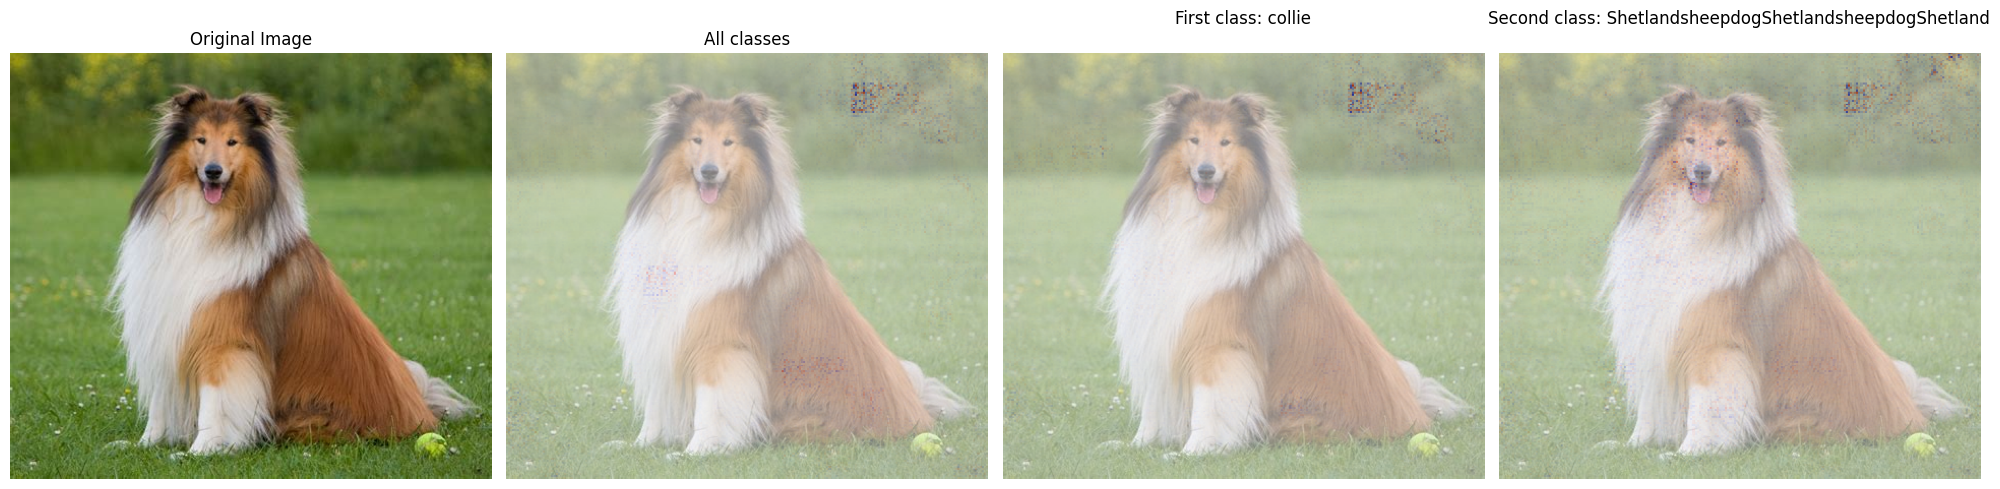

In [12]:
from crp.image import imgify


max_abs_val1 = torch.max(torch.abs(attr1.heatmap))
# resize the heatmap to the original image size
heatmap__pil1 = imgify(attr1.heatmap, vmin=-max_abs_val1, vmax=max_abs_val1)
max_abs_val2 = torch.max(torch.abs(attr2.heatmap))
heatmap__pil2 = imgify(attr2.heatmap, vmin=-max_abs_val2, vmax=max_abs_val2)
max_abs_val3 = torch.max(torch.abs(attr3.heatmap))
heatmap__pil3 = imgify(attr3.heatmap, vmin=-max_abs_val3, vmax=max_abs_val3)
print(max_abs_val1, max_abs_val2, max_abs_val3)

# Display the heatmaps in line with the original image
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.tight_layout()
plt.subplot(1, 4, 2)
plt.imshow(image)
heatmap__pil1 = heatmap__pil1.resize(image.size, Image.BILINEAR)
plt.imshow(heatmap__pil1, alpha=0.5, cmap='jet')
plt.title("All classes")
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(image)
heatmap__pil2 = heatmap__pil2.resize(image.size, Image.BILINEAR)
plt.imshow(heatmap__pil2, alpha=0.5, cmap='jet')
plt.title("First class: " + index_to_label[output_class])
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(image)
heatmap__pil3 = heatmap__pil3.resize(image.size, Image.BILINEAR)
plt.imshow(heatmap__pil3, alpha=0.5, cmap='jet')
plt.title("Second class: " + index_to_label[second_output_class])
plt.axis('off')
plt.show()
# Save the heatmaps as images

# Study of the important features in general.

On this part, we are going to separate between the main class and the important features on the layer of features. We will check for features normals in the whole dataset and features normal, in the whole  

In [13]:
last_layer_names = get_layer_names(
    model, types=[torch.nn.Conv2d, torch.nn.Linear, torch.nn.AdaptiveAvgPool2d]
)[-3:]

from zennit.composites import EpsilonPlusFlat

composite = EpsilonPlusFlat([])

print("Last layer names:", last_layer_names)
# Get the last layer's weights


conditions1 = [{"y": second_output_class}]

attr1 = attribution(sample,conditions1,composite=composite,record_layer=last_layer_names)

Last layer names: ['features.7.1.mlp.3', 'avgpool', 'head']


torch.Size([1, 7, 7, 1024]) torch.Size([1, 7, 7, 1024])
Most important feature position in features.7.1.mlp.3: 10327


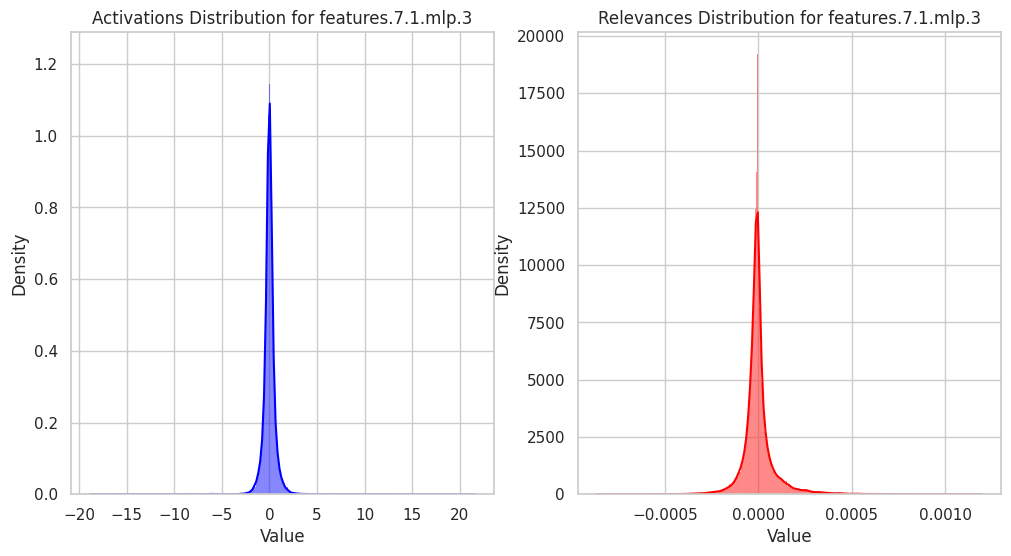

torch.Size([1, 1024, 1, 1]) torch.Size([1, 1024, 1, 1])
Most important feature position in avgpool: 229


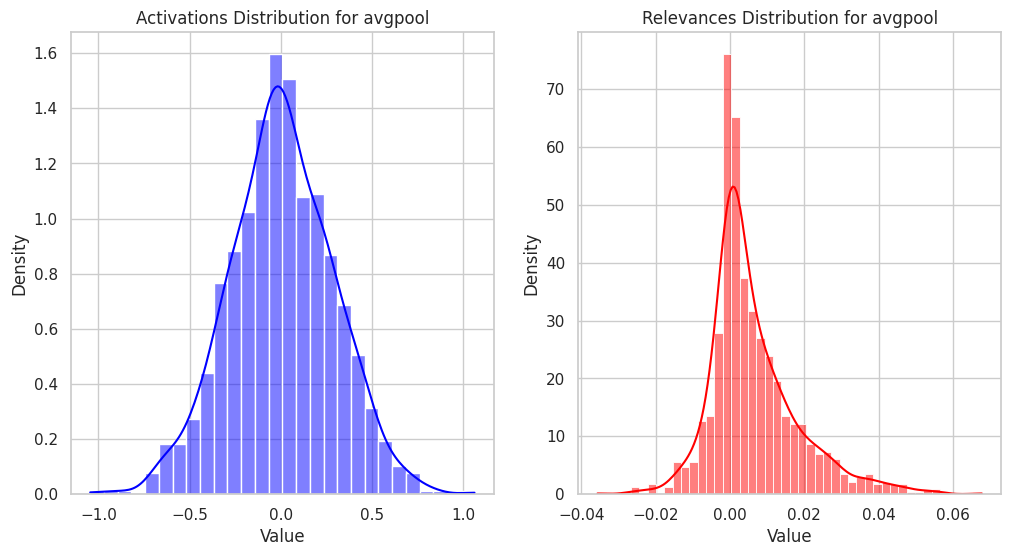

torch.Size([1, 1000]) torch.Size([1, 1000])
Most important feature position in head: 230


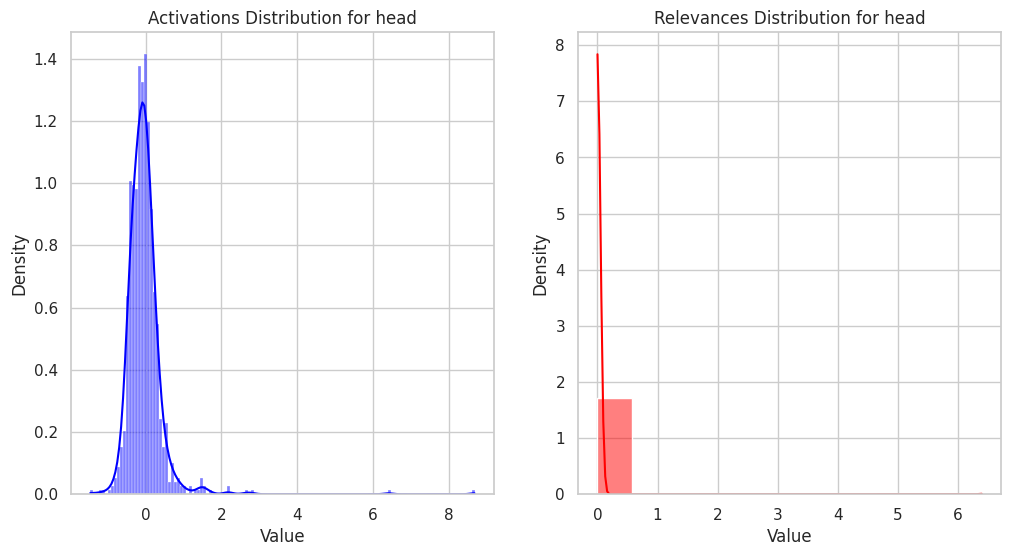

In [14]:
import seaborn as sns
sns.set(style="whitegrid")
for layer in last_layer_names:
    print(attr1.activations[layer].shape, attr1.relevances[layer].shape)
    
    # Flatten the activations and relevances and plot them as a distribution plot one on the left and one on the right
    print(f"Most important feature position in {layer}: {attr1.relevances[layer].argmax().item()}")
    activations_flat = attr1.activations[layer].flatten().cpu().detach().numpy()
    relevances_flat = attr1.relevances[layer].flatten().cpu().detach().numpy()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(activations_flat, kde=True, label='Activations', color='blue', stat='density')
    plt.title(f'Activations Distribution for {layer}')
    plt.xlabel('Value')
    plt.ylabel('Density')

    plt.subplot(1, 2, 2)
    sns.histplot(relevances_flat, kde=True, label='Relevances', color='red', stat='density')
    plt.title(f'Relevances Distribution for {layer}')
    plt.xlabel('Value')
    plt.ylabel('Density')

    # Render in the notebook so i can zoom in
    plt.show()
    

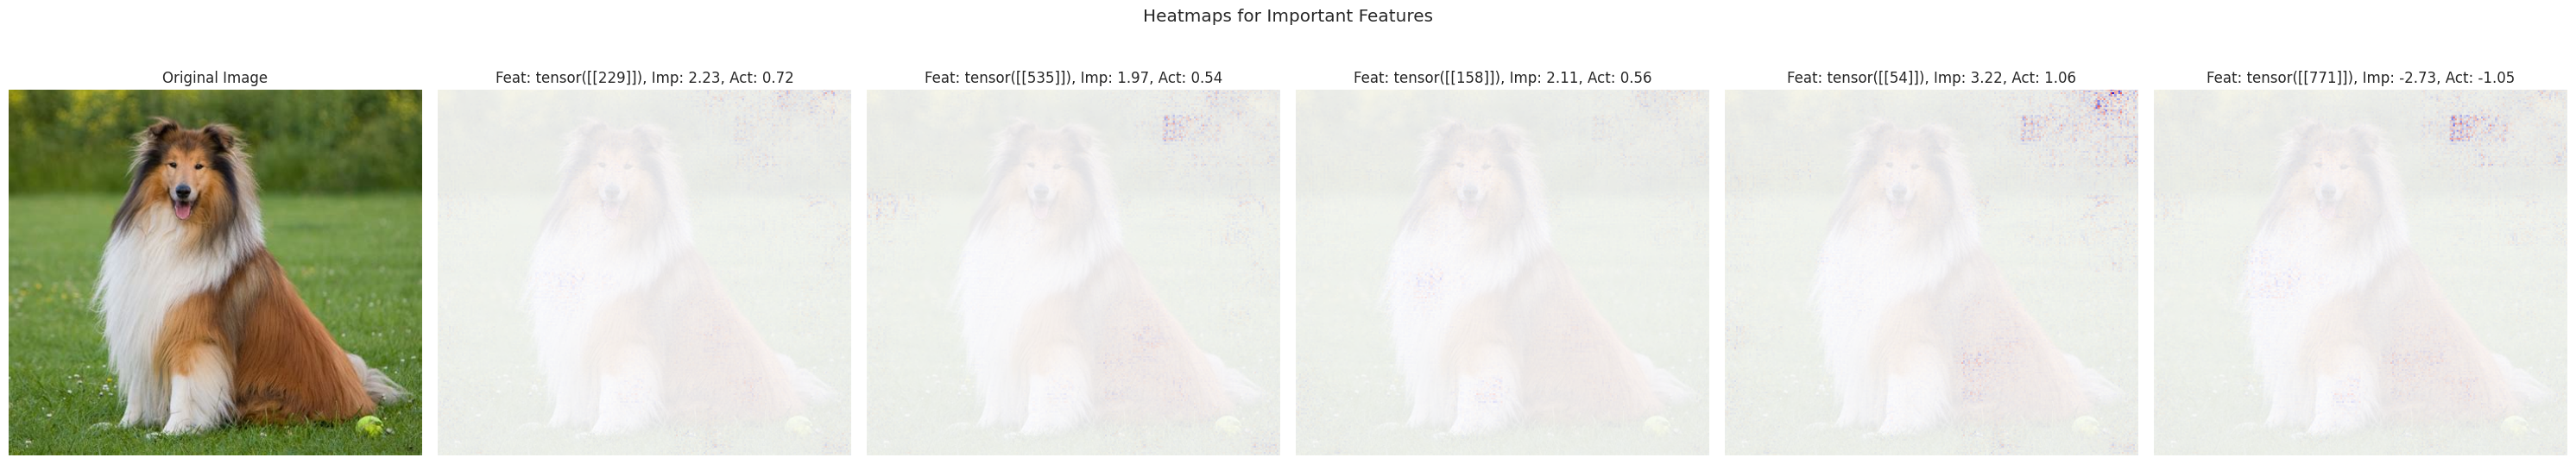

In [16]:
layer = last_layer_names[-2]  
importants = attr1.relevances[layer]

importants = torch.topk(importants,5,dim=1)[1][0]

# condition = [{"y": range(1000), last_layer_names[-2]: [i]} for i in importants]
condition = [{"y": range(1000) , last_layer_names[-2]: [i]} for i in importants]
attr = attribution(sample, condition)
max_abs_val1 = torch.max(torch.abs(attr.heatmap))

# Importances of the last_layer_names[-2]

importances = attr.relevances[last_layer_names[-2]]
activations = attr.activations[last_layer_names[-2]]


# Display the original image and the heatmaps for the important features, the first in the left and one by one on the right

plt.figure(figsize=(30, 6))
for i, heatmap in enumerate(attr.heatmap):
    plt.subplot(1, len(importants) + 1, i + 2)
    img = imgify(heatmap, vmin=-max_abs_val1, vmax=max_abs_val1)
    img = img.resize(image.size, Image.BILINEAR)
    plt.imshow(image)
    plt.imshow(img, alpha=0.9, cmap="jet")
    plt.title(f"Feat: {importants[i]}, Imp: {torch.sum(importances[0][importants[i]]).item():.2f}, Act: {torch.sum(activations[0][importants[i]]).item():.2f}")
    plt.axis('off')
    plt.tight_layout()
plt.subplot(1, len(importants) + 1, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.tight_layout()
plt.suptitle("Heatmaps for Important Features")

plt.tight_layout()

plt.show()